In [1]:
import hylite
import numpy as np
import hylite.io as io
import matplotlib.pyplot as plt

import os
from pathlib import Path
from tqdm.auto import tqdm
import cv2

In [2]:
import h5py

In [3]:
from pyproj import CRS

In [4]:
%matplotlib inline

100%|██████████| 23/23 [00:19<00:00,  1.19it/s]


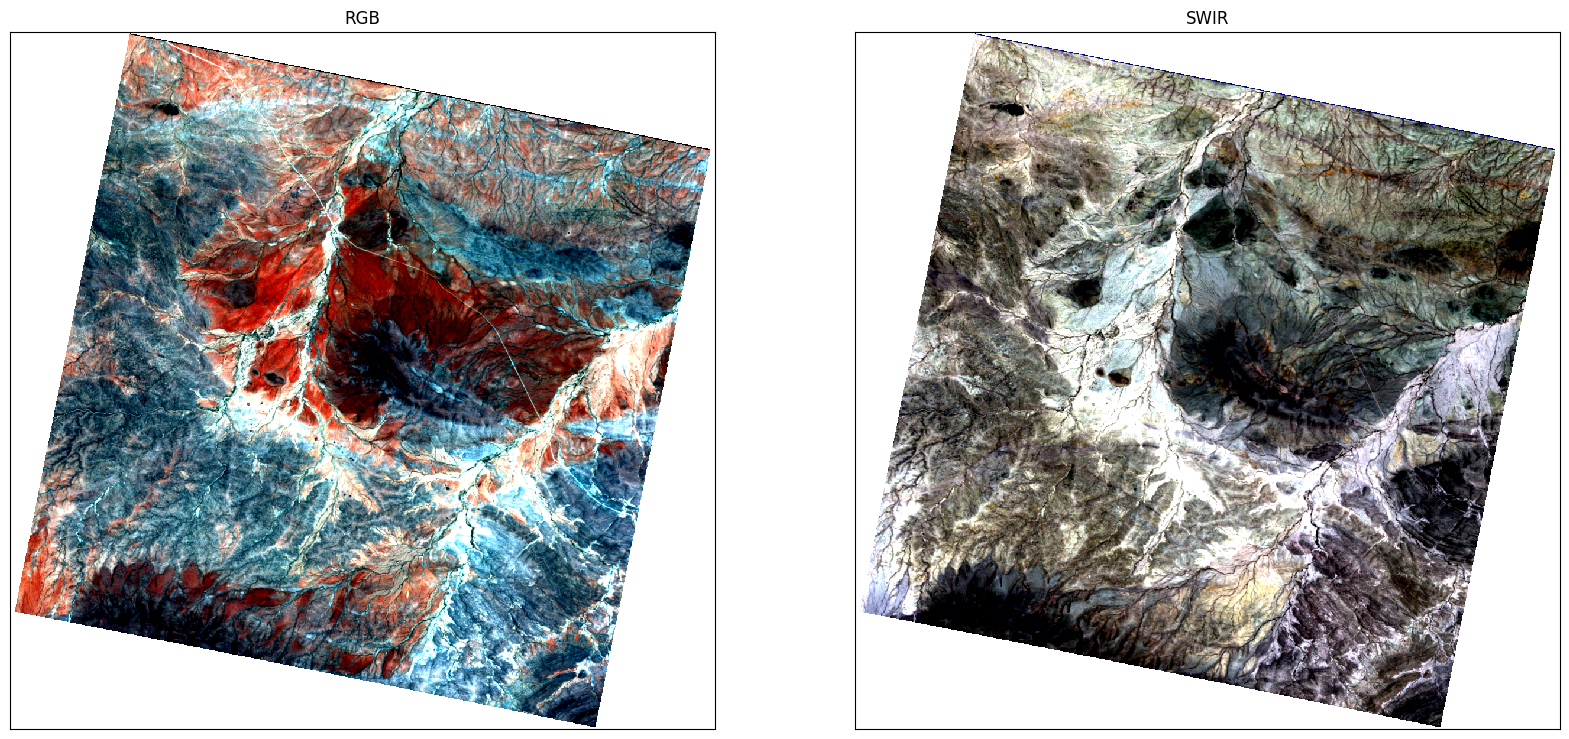

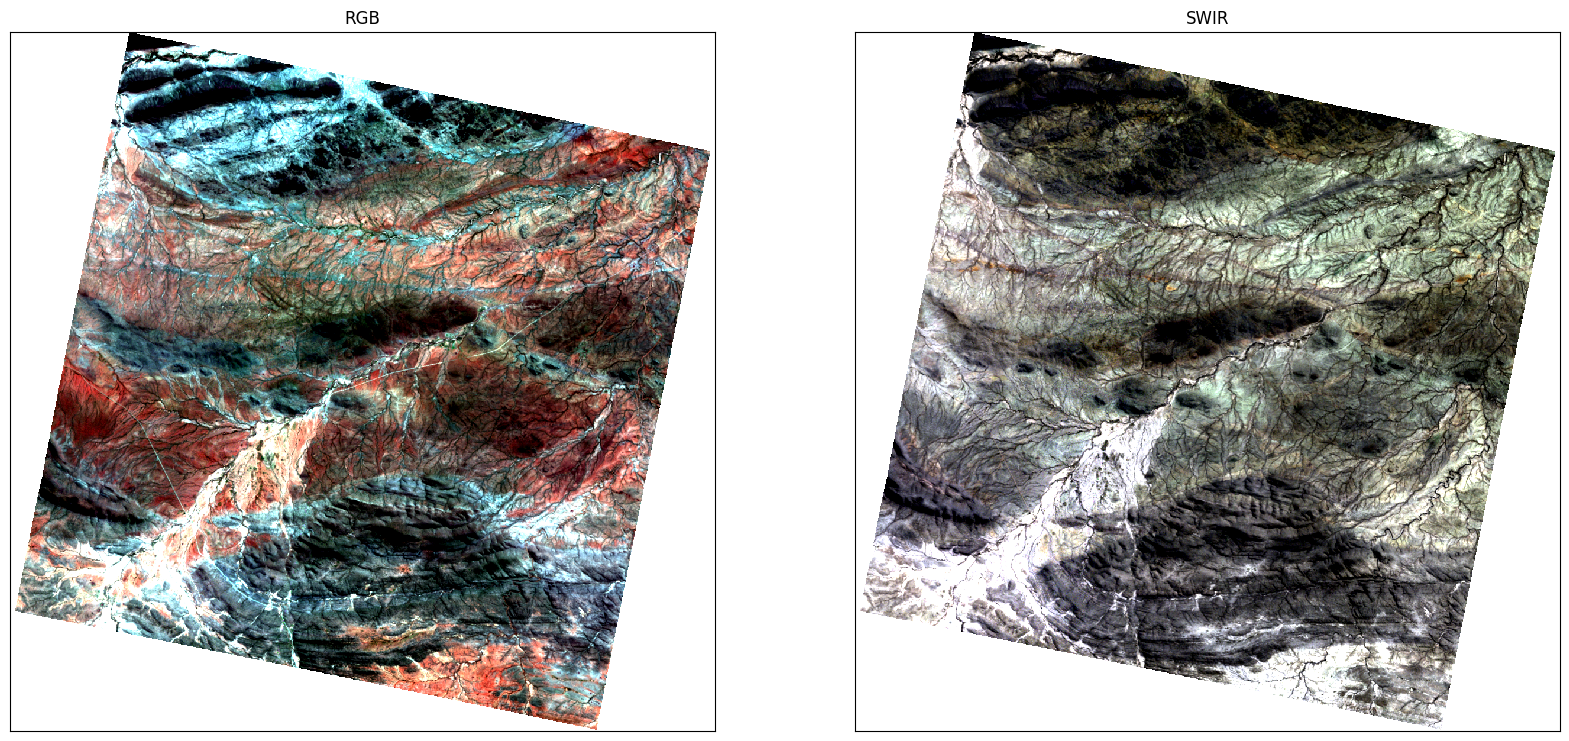

In [6]:
dr = Path( '/Users/rachdi18/Documents/Namibia_Epembe/PRISMA/' )
out = Path( '/Users/rachdi18/Documents/Namibia_Epembe/PRISMA/' )
for fp in tqdm(os.listdir(dr)):
    if '.he5' not in fp:
        continue # skip non-he5 files

    f=h5py.File(str(dr / fp), "r")

    wl_VNIR = np.flipud(f.attrs['List_Cw_Vnir'])
    wl_SWIR = np.flipud(f.attrs['List_Cw_Swir'])
    VNIR_valid = np.argwhere(wl_VNIR>0.)[:,0]
    SWIR_valid = np.argwhere((wl_SWIR>0.) *(wl_SWIR>np.amax(wl_VNIR)))[:,0]
    wl = np.hstack((wl_VNIR[VNIR_valid],wl_SWIR[SWIR_valid]))

    VNIRdata = f['/HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/VNIR_Cube'][:,:,:]
    SWIRdata = f['/HDFEOS/SWATHS/PRS_L2D_HCO/Data Fields/SWIR_Cube'][:,:,:]
    VNIRdata = np.transpose(VNIRdata, (2,0,1))[...,::-1][...,VNIR_valid]
    SWIRdata = np.transpose(SWIRdata, (2,0,1))[...,::-1][...,SWIR_valid]
    VNIRdata.shape, SWIRdata.shape
    HSI = np.clip( np.dstack((VNIRdata, SWIRdata)),0.0,np.inf)

    easting = f.attrs['Product_ULcorner_easting']
    northing = f.attrs['Product_ULcorner_northing']
    UTM_zone = int(f.attrs['Projection_Id'])

    # convert utm zone to epsg code
    crs = CRS.from_string('+proj=utm +zone=%s +south'%UTM_zone)
    epsg = crs.to_authority()[1]

    image = io.HyImage(HSI)
    image.set_wavelengths(wl)
    image.set_projection_EPSG('EPSG:%s'%epsg)
    image.affine = [easting, 30., 0, northing, 0.,-30.]
    image.decompress()
    image.set_as_nan(0)

    clouds = f['/HDFEOS/SWATHS/PRS_L2D_PCO/Data Fields/PIXEL_L2_ERR_MATRIX'][:,:]
    clouds = np.transpose(cv2.resize(clouds, HSI.shape[0:2])) # downsample to match HSI
    cloudmask = clouds >= 0.9
    image.data[cloudmask,:] = np.nan

    fig,ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].set_title("RGB")
    image.quick_plot(hylite.RGB,ax=ax[0], tscale=True, vmin=5, vmax=95)
    ax[1].set_title("SWIR")
    image.quick_plot(hylite.SWIR,ax=ax[1],tscale=True, vmin=5, vmax=95)
    fig.show()

    # save
    image.compress()
    io.save(str( out / (os.path.splitext(fp)[0] + ".hdr")), image )